In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
#datset path
#dataset='ds'
#train_directory = os.path.join(dataset, 'train')
#valid_directory = os.path.join(dataset, 'valid')
#test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

num_classes = len(os.listdir(valid_directory)) 
print(num_classes)


data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

#to print the animal names
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

#length of data
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

#Data Loading
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

10
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [4]:

train_data_size, valid_data_size, test_data_size

(600, 100, 409)

In [5]:
resnet50 = models.resnet50(pretrained=True)
#resnet50 = resnet50.to('cuda:0')
for param in resnet50.parameters():
    param.requires_grad = False

In [6]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1) 
)


#resnet50 = resnet50.to('cuda:0')

In [7]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [8]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
                # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
                # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 25
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/25
Epoch : 000, Training: Loss: 1.5927, Accuracy: 49.0000%, 
		Validation : Loss : 0.6349, Accuracy: 85.0000%
Epoch: 2/25
Epoch : 001, Training: Loss: 0.5151, Accuracy: 89.5000%, 
		Validation : Loss : 0.3023, Accuracy: 96.0000%
Epoch: 3/25
Epoch : 002, Training: Loss: 0.3352, Accuracy: 91.1667%, 
		Validation : Loss : 0.2600, Accuracy: 92.0000%
Epoch: 4/25
Epoch : 003, Training: Loss: 0.2397, Accuracy: 94.5000%, 
		Validation : Loss : 0.1668, Accuracy: 96.0000%
Epoch: 5/25
Epoch : 004, Training: Loss: 0.1716, Accuracy: 94.6667%, 
		Validation : Loss : 0.1599, Accuracy: 97.0000%
Epoch: 6/25
Epoch : 005, Training: Loss: 0.1876, Accuracy: 94.3333%, 
		Validation : Loss : 0.1699, Accuracy: 96.0000%
Epoch: 7/25
Epoch : 006, Training: Loss: 0.1393, Accuracy: 96.5000%, 
		Validation : Loss : 0.1712, Accuracy: 95.0000%
Epoch: 8/25
Epoch : 007, Training: Loss: 0.1871, Accuracy: 94.1667%, 
		Validation : Loss : 0.1631, Accuracy: 97.0000%
Epoch: 9/25
Epoch : 008, Training: Loss: 0.1392,

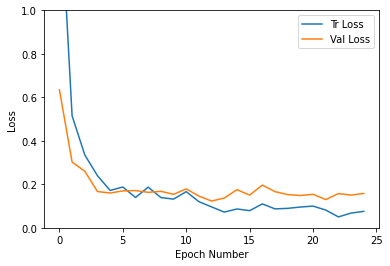

In [19]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

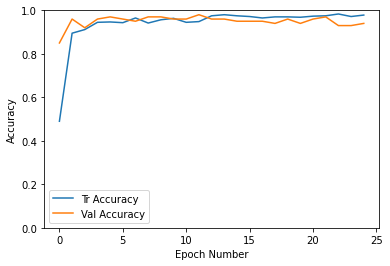

In [20]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [9]:
def computeTestSetAccuracy(model, loss_criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            #print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [10]:
def predict(model, test_image_name):
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    #if torch.cuda.is_available():
        #test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
   # else:
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

In [11]:
dataset = 'ds'
model = torch.load('ds_model_11.pt')
# Load the model with greatest validation accuracy, low validation loss and a fairly high training accuracy.


Enter the file name :abc
Predcition 1 : bear , Score:  0.9998853
Predcition 2 : porcupine , Score:  2.8140035e-05
Predcition 3 : llama , Score:  2.6986108e-05


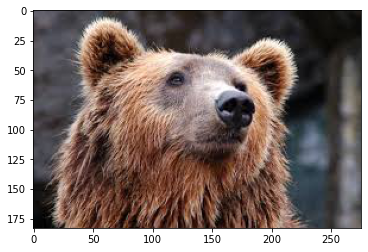

In [17]:
# Download any animal image and place it in the appropriate path
string=input('Enter the file name :')
#test_image = 'ds/images/'+string+'.jpg'
predict(model, test_image)


In [18]:
computeTestSetAccuracy(model, loss_func)

Test accuracy : 0.9437652798620004
